## Define the Settings

Setting up which GPU you are using.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

If you encounter error while building the plugins for StyleGAN2, it may probably be caused by the missing path of ninja.
Thus, explicitly adding the path of ninja to the `PATH` environment variable may help.

You can query the path by typing `which ninja` in the conda environment and extract the directory component.

In [2]:
# Uncomment this line if you encounter the error (at least worth a try ;D)
# os.environ['PATH'] = os.environ['PATH'] + ":path-to-ninja(directory only)"

In [3]:
device = "cuda"

In [4]:
from zoo import *
zoo = ModelZoo(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/jiangkaiwen/anaconda3/envs/NeRFFaceEditing/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


## Testing the EG3D

In [5]:
import imageio
from tqdm import tqdm
@torch.no_grad()
def render_video(
    fn: str, 
    ws: torch.Tensor, 
    fps: int = 30, 
    a_degree: float = 15, 
    b_degree: float = 12, 
    frames: int = 150, 
):
    a = a_degree / 180 * np.pi
    b = b_degree / 180 * np.pi
    
    planes = encode(G, ws, **synthesis_kwargs)
    
    def get_image(camera):
        img = decode(G, ws, *planes, cam=camera, double_sample_points=True, **synthesis_kwargs)[1]
        
        img = np.asarray(img.cpu().numpy(), dtype=np.float16)
        img = (img - (-1)) * (255 / (1 - (-1)))
        img = np.rint(img).clip(0, 255).astype(np.uint8)[0]
        img = img.transpose(1, 2, 0)
        return img
    
    os.makedirs(os.path.dirname(fn), exist_ok=True)
    writer = imageio.get_writer(fn, fps=fps, quality=8)
    for index in tqdm(range(frames)):
        theta = index / (frames - 1) * 2 * np.pi
        h_delta = a * np.cos(theta)
        v_delta = b * np.sin(theta)
        camera = torch.from_numpy(np.array([[ np.pi / 2 + h_delta,  np.pi / 2 + v_delta,  0.,  1.,  0., 0.]], dtype=np.float32)).to(z.device)
        writer.append_data(get_image(camera))
    writer.close()

In [6]:
G = zoo.get_EG3D(0)

In [7]:
torch.manual_seed(0)

In [8]:
z = torch.randn([1, G.z_dim]).to(device)

In [9]:
# Define the Camera
# Each corresponding to `yaw`, `pitch`, `roll`, `radius`, `translation of x` and `translation of y`.
cam = torch.from_numpy(np.array([[ np.pi / 2, np.pi / 2,  0.,  1.,  0., 0.]], dtype=np.float32)).to(device)

In [10]:
with torch.no_grad():
    # Mapping latent code into intermediate ones
    w = mapping(G, z, zoo.frontal_cam, .5)
    # Use StyleGAN2 to generate tri-planes
    planes = encode(G, w, **synthesis_kwargs)
    # Calling Decoder & Perform Volume Rendering
    _, image, _ = decode(G, w, *planes, cam=cam, **synthesis_kwargs)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


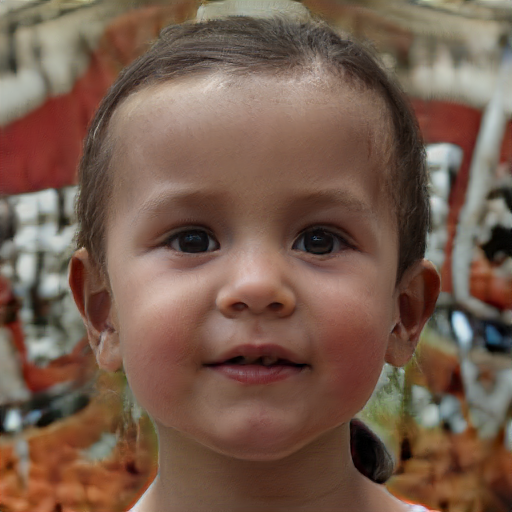

In [11]:
render_tensor(image.clamp(-1., 1.))

In [11]:
# Render a Video
render_video("./debug/00000.mp4", w)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.79it/s]


### Inversion

For those who are interested in the projection, I provide an example here.

In [12]:
from projector import Projector

In [13]:
projector = Projector(zoo)

creating the FLAME Decoder


An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/home/jiangkaiwen/anaconda3/envs/NeRFFaceEditing/lib/python3.10/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/home/jiangkaiwen/anaconda3/envs/NeRFFaceEditing/lib/python3.10/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt


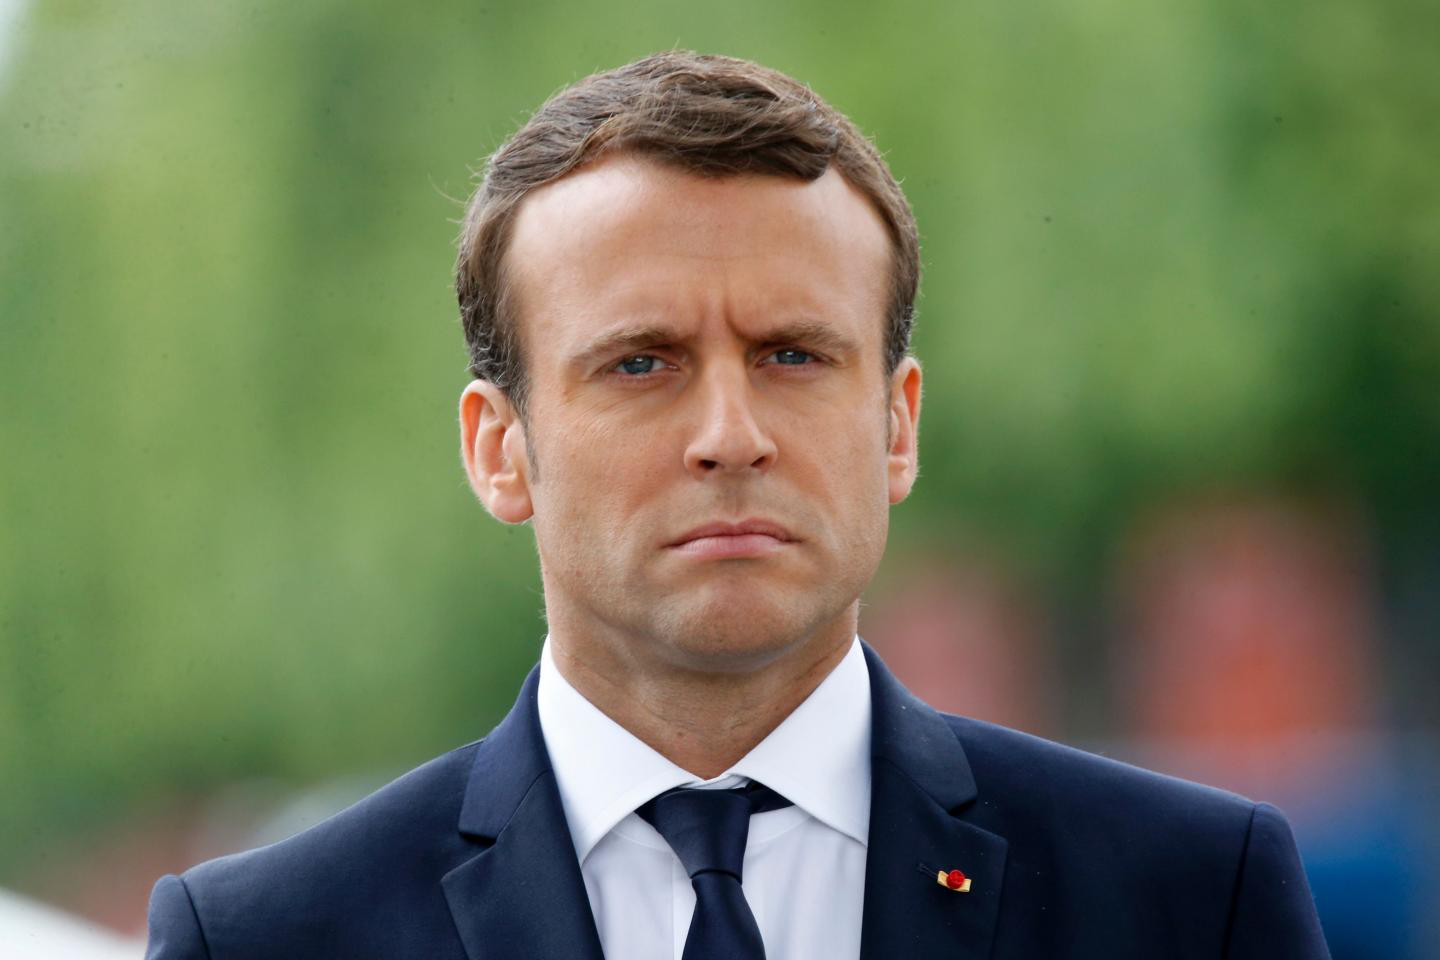

In [14]:
image = Image.open(os.path.join("./data", "test.jpg"))
display(image)

In [15]:
cropped_image, pred_pose, (G_opt, w_opt) = projector.forward(image)

tensor([[ 1.6536,  1.5078, -0.0247,  1.0000,  0.0000,  0.0000]],
       device='cuda:0')


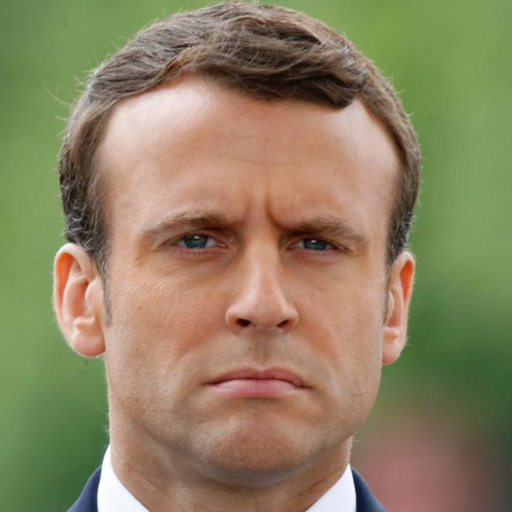

In [16]:
print(pred_pose)
display(cropped_image)

In [17]:
with torch.no_grad():
    planes = encode(G_opt, w_opt, **synthesis_kwargs)
    _, image, _ = decode(G_opt, w_opt, *planes, cam=zoo.frontal_cam, **synthesis_kwargs)

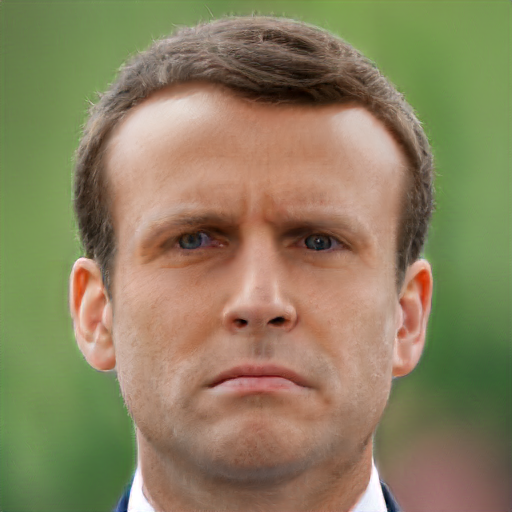

In [18]:
render_tensor(image.clamp(-1, 1))

## Testing the NeRFFaceEditing

In [6]:
G = zoo.get_EG3D(1)

In [16]:
import imageio
from tqdm import tqdm
@torch.no_grad()
def render_video(
    fn: str, 
    ws: torch.Tensor, 
    app_features, 
    fps: int = 30, 
    a_degree: float = 15, 
    b_degree: float = 12, 
    frames: int = 150, 
):
    a = a_degree / 180 * np.pi
    b = b_degree / 180 * np.pi
    
    def convert_image(img):
        img = np.asarray(img.cpu().numpy(), dtype=np.float16)
        img = (img - (-1)) * (255 / (1 - (-1)))
        img = np.rint(img).clip(0, 255).astype(np.uint8)[0]
        img = img.transpose(1, 2, 0)
        return img
    
    def get_image(camera):
        _, img, _, seg = decode_with_features(G, ws, pose=camera, **app_features)
        
        return np.concatenate([convert_image(img), convert_image(vis_parsing_maps(resample_semantic_masks(seg)))], axis=1)
    
    os.makedirs(os.path.dirname(fn), exist_ok=True)
    writer = imageio.get_writer(fn, fps=fps, quality=8)
    for index in tqdm(range(frames)):
        theta = index / (frames - 1) * 2 * np.pi
        h_delta = a * np.cos(theta)
        v_delta = b * np.sin(theta)
        camera = torch.from_numpy(np.array([[ np.pi / 2 + h_delta,  np.pi / 2 + v_delta,  0.,  1.,  0., 0.]], dtype=np.float32)).to(z.device)
        writer.append_data(get_image(camera))
    writer.close()

### Generation

In [7]:
torch.manual_seed(1)

In [8]:
z = torch.randn([1, G.z_dim]).to(device)

In [9]:
# Define the Camera
# Each corresponding to `yaw`, `pitch`, `roll`, `radius`, `translation of x` and `translation of y`.
cam = torch.from_numpy(np.array([[ np.pi / 2, np.pi / 2,  0.,  1.,  0., 0.]], dtype=np.float32)).to(device)

In [10]:
with torch.no_grad():
    # Mapping latent code into intermediate ones
    w = mapping(G, z, zoo.frontal_cam, .5)
    # Extract Appearance Features
    app_features = extract_plane_features(G, w)
    # Calling Decoder & Perform Volume Rendering
    _, image, _, seg = decode_with_features(G, w, pose=cam, **app_features)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


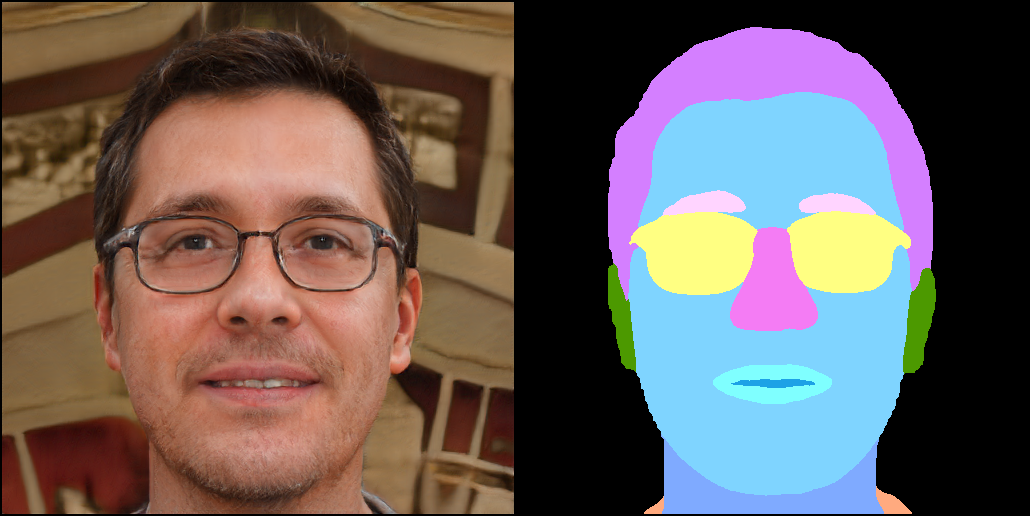

In [11]:
render_tensor([image.clamp(-1, 1), vis_parsing_maps(resample_semantic_masks(seg))])

In [17]:
render_video("./debug/00001.mp4", w, app_features)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:44<00:00,  3.41it/s]


### Editing via Semantic Masks

In [19]:
from torchvision import transforms
read_seg = lambda fn: (transforms.ToTensor()(Image.open(fn).convert('RGB')) * 2 - 1).unsqueeze(0).to(device)

Original Semantic Masks


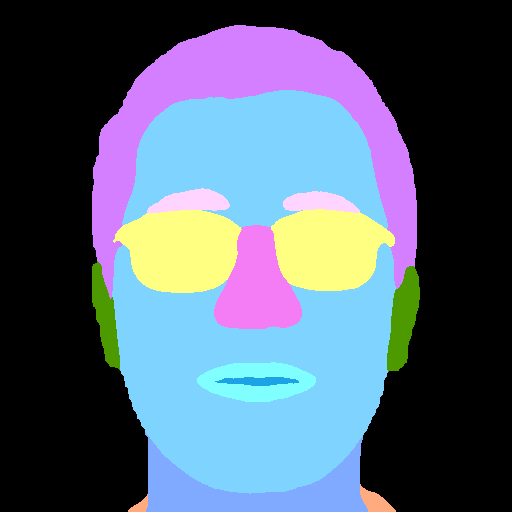

In [18]:
print("Original Semantic Masks")
render_tensor([vis_parsing_maps(resample_semantic_masks(seg))])

Modified Semantic Masks


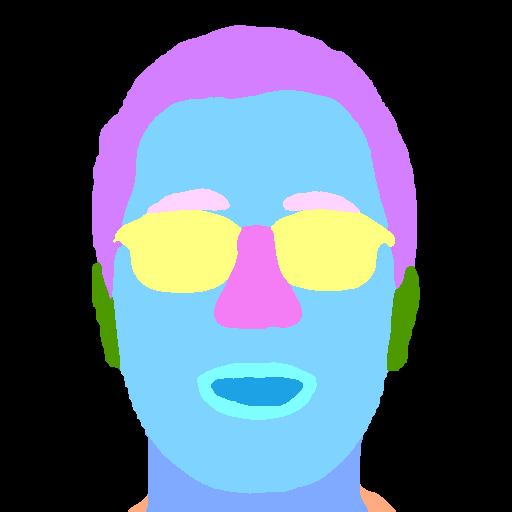

In [22]:
print("Modified Semantic Masks")
target_seg = vis_parsing_maps(read_seg(os.path.join("./data", "seg.png")), inverse=True)
display(render_tensor(vis_parsing_maps(target_seg, argmax=False)))
target_seg = resample_semantic_masks(target_seg)

In [24]:
with torch.no_grad():
    original_image, _, _, original_seg = decode_with_features(G, w, pose=cam, **app_features)
modified_mask = ( original_seg.argmax(dim=1, keepdims=True) != target_seg ).float()

In [29]:
with torch.no_grad():
    delta_w = torch.randn_like(w[:, :1]).repeat(1, w.size(1), 1) * 0.01
delta_w = delta_w.requires_grad_(True)

optimizer = torch.optim.Adam([delta_w], lr=0.02, betas=(0.9, 0.999))

In [30]:
for step in tqdm(range(100)):
    # Step
    optimizer.zero_grad(set_to_none=True)
    
    # Expand base code
    ws = w + delta_w

    pred_image, _, _, pred_seg = decode_with_features(G, ws, pose=cam, **app_features)

    loss_seg = torch.nn.CrossEntropyLoss()(pred_seg, target_seg.squeeze(1))
    loss_consist = zoo.lpips_loss((1 - modified_mask) * original_image, (1 - modified_mask) * pred_image).mean() + \
                    torch.nn.MSELoss()((1 - modified_mask) * original_image, (1 - modified_mask) * pred_image)

    loss = loss_seg + loss_consist

    loss.backward()
    optimizer.step()
with torch.no_grad():
    ws = (w + delta_w).detach().clone()

In [31]:
with torch.no_grad():
    _, opt_image, _, opt_seg = decode_with_features(G, ws, pose=cam, **app_features)

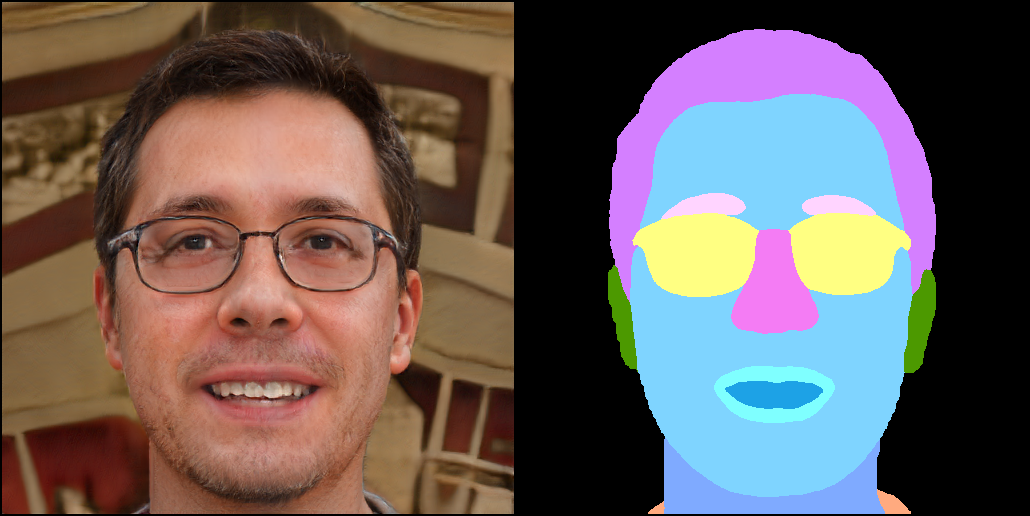

In [32]:
render_tensor([opt_image.clamp(-1, 1), vis_parsing_maps(resample_semantic_masks(opt_seg))])

### Style Transfer

In [34]:
torch.manual_seed(2)

In [35]:
z = torch.randn([1, G.z_dim]).to(device)

In [42]:
with torch.no_grad():
    # Mapping latent code into intermediate ones
    w_app = mapping(G, z, zoo.frontal_cam, .5)
    # Extract Appearance Features
    ref_app_features = extract_plane_features(G, w_app)
    # Calling Decoder & Perform Volume Rendering
    _, app_image, _, _ = decode_with_features(G, w_app, pose=cam, **ref_app_features)
    
    # Apply the Appearance Features to the previous Edited Geometry Features
    _, transfer_image, _, _ = decode_with_features(G, ws, pose=cam, **ref_app_features)

Geometry, Appearance, Style Transfer Results


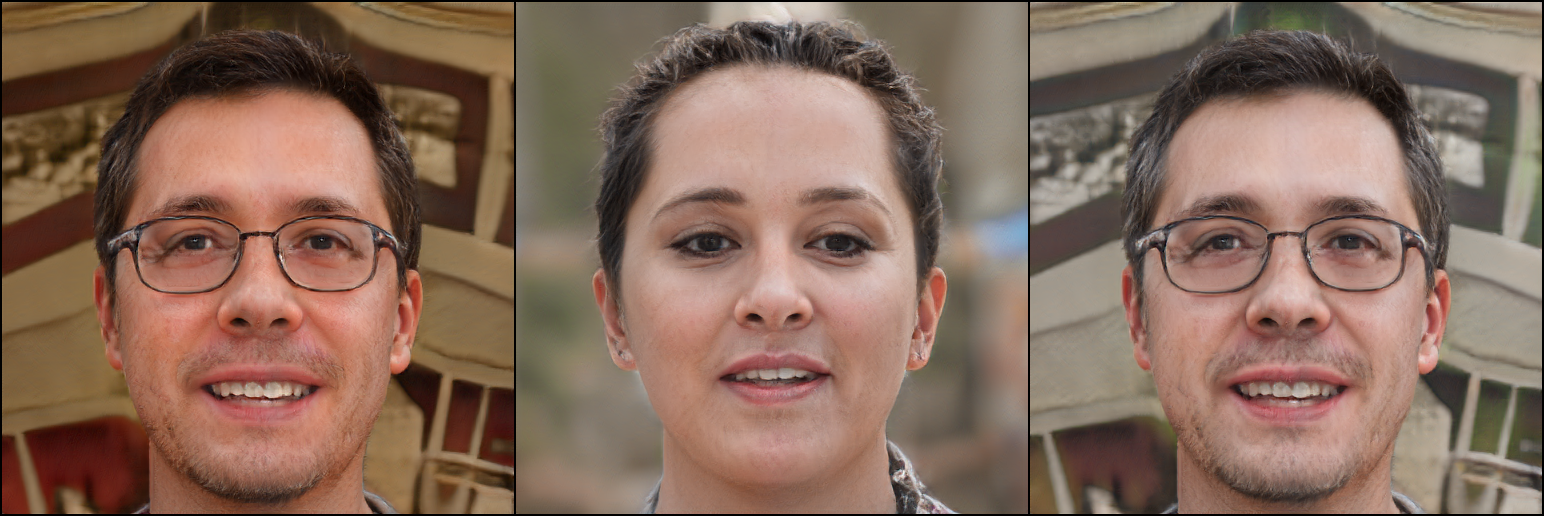

In [43]:
print("Geometry, Appearance, Style Transfer Results")
render_tensor([opt_image.clamp(-1, 1), app_image.clamp(-1, 1), transfer_image.clamp(-1, 1)])